# Computational Approaches to the Study of Food Sign Patterns
Today, we're going to explore the ways in which restaurants of different cuisines describe food on their menus. Specifically, we're interested in the following questions about food cultures in Chicago:
1. Are there patterns in the ways in which particular cuisine genres describe food on menus?
    * Identification of dicent indexical/iconic legisigns that position a particular restaurant within a cuisine (which can then be used by consumers to position themselves in the same light via social media posts, and so on)
2. Are these cuisines (and/or menu discourse patterns identified in #1) geographically patterned?
    * Identification of dicent indexical legisigns that point to a particular cuisine or broader menu discourse pattern on the basis of spatial location
    
First, let's load our packages. In order to run this notebook, you will need to install the `folium` package, which is available to install through the Anaconda Navigator or on the command line via the command `conda install -c conda-forge folium`

In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from gensim import corpora, models
from sklearn.manifold import TSNE
import folium

# Some Functions from last time to get us started:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    # Combine list elements together into a single string for analysis
    text = ' '.join(text)

    # Note the addition of some size-related stop words that are specific to Menu data and need to be removed
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation) + ['comma', 'oz', '32', '32oz',
                                                                                '16oz', '12', 'amp', 'w/', 'w.',
                                                                                'z'
                                                                               ]
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def plot_top_tfidf(series, data_description):
    # Apply 'get lemmas' function to any Pandas Series that we pass in to get lemmas for each row in the Series
    lemmas = series.apply(get_lemmas)

    # Initialize Series of lemmas as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in lemmas])

    # Convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]

    # Calculate TFIDF based on bag of words counts for each token and return weights:
    tfidf = models.TfidfModel(bow_corpus)
    tfidf_weights=[]
    
    for doc in tfidf[bow_corpus]:
        tfidf_weights.extend([[dictionary[ID], np.around(freq, decimals=2)] for ID, freq in doc])

    # Sort TFIDF weights highest to lowest:
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

    # Plot the top 10 weighted words:
    top_10 = {k:v for k,v in sorted_tfidf_weights[:10]} # dictionary comprehension
    plt.plot(list(top_10.keys()), list(top_10.values()), label=data_description)
    plt.xticks(rotation='vertical')
    plt.title('Top 10 Lemmas (TFIDF) for ' + data_description);

    return

# ... and some new functions that we'll work with today:

def get_menu_data(url, uid, cuisine):
    '''
    Takes allmenus.com url and a restaurant unique id number
    (so that restaurants with the same name are uniquely identifiable)
    Returns Dictionary: {UID:{Cuisine, Restaurant Name,
                              Coordinates, Menu:{Dish Names, Dish Descriptions}
                        }
    '''
    # Get HTML, parse it, and identify JSON containing Restaurant/Menu Data
    html = requests.get(url)
    soup = BeautifulSoup(html.text, "html.parser")
    restaurant_data = soup.find('script', type='application/ld+json')
    try:
        # set strict to False, so that control characters like \n are allowed within the text:
        restaurant_data_json = json.loads(restaurant_data.text, strict=False)
    except:
        return {uid: {'Cuisine': cuisine,
                       'Restaurant': None,
                       'Coordinates': None,
                       'Menu Items': None,
                       'Item Descriptions': None,
                       'URL': url
                }}
    try:
        # Store each menu item (a dictionary) into nested_items variable for retrieving item names and descriptions below:
        nested_items = [section['hasMenuItem'] for section in restaurant_data_json['hasMenu'][0]['hasMenuSection']]

        # Store Data for individual menu/restaurant in a dictionary to enable easy aggregation into a Pandas DataFrame:
        menu_data = {uid: {'Cuisine': cuisine,
                       'Restaurant': restaurant_data_json['name'],
                       'Coordinates': (restaurant_data_json['geo']['latitude'], restaurant_data_json['geo']['longitude']),
                       'Menu Items': [j['name'] for i in nested_items for j in i],
                       'Item Descriptions': [j['description'] for i in nested_items for j in i],
                       'URL': url
                }}
    except:
        menu_data = {uid: {'Cuisine': cuisine,
                       'Restaurant': restaurant_data_json['name'],
                       'Coordinates': (restaurant_data_json['geo']['latitude'], restaurant_data_json['geo']['longitude']),
                       'Menu Items': None,
                       'Item Descriptions': None,
                       'URL': url
                }}

    return menu_data

def scrape_top_menus(cuisine_list, topn=10):
    # Create a Dictionary for holding every cuisine's restaurant/menu data:
    cuisine_dict = {}
    # Incremental count for assigning unique identification numbers to each restaurant
    count = 0

    # Scrape top n (parameter topn) restaurant links from allmenus.com for each cuisine:
    for cuisine in cuisine_list:
        # Get cuisine's popularity-sorted list of restaurants
        html = requests.get('https://www.allmenus.com/il/chicago/-/' + cuisine + '/')
        soup = BeautifulSoup(html.text, "html.parser")

        # Find links where class != grubhub (these take you to Grubhub's website, rather than the allmenus page we want)
        restaurant_anchors = soup.find('ul', class_="restaurant-list").findAll("a", class_=None)
        restaurant_links = ['https://www.allmenus.com' + i.get('href') for i in restaurant_anchors[:topn]]

        # Loop through each Restaurant's allmenus.com webpage and get its menu data:
        menu_dict = {}
        for restaurant in restaurant_links:
            dict_temp = {}
            dict_temp = get_menu_data(url = restaurant,
                                         uid = count,
                                         cuisine=cuisine)
            menu_dict.update(dict_temp)
            count += 1
        cuisine_dict.update(menu_dict)


    return pd.DataFrame(cuisine_dict).T

def make_folium_pt_map(menu_df):
    m = folium.Map(zoom_start=12, location=[41.8507, -87.6340], tiles='CartoDB positron')

    for point in menu_df.index:
        popup_content = '<b>Restaurant: </b>' + menu_df['Restaurant'][point] + '\n' + '<b>Cuisine: </b>' + menu_df['Cuisine'][point].capitalize()
        
        # Colors are baked into the function, so we won't be able to reassign colors/cuisines without reorganizing:
        color_cuisine = {'italian': 'red','soul-food': 'blue', 'latin-american': 'green', 'gastropub': 'purple',
                         'polish': 'orange', 'late-night': 'darkred', 'thai': 'black', 'chinese': 'pink',
                         'korean': 'darkblue', 'vegan_vegetarian':'lightgreen'
                        }
        color_icon_body = color_cuisine[menu_df['Cuisine'][point]]

        folium.Marker(menu_df['Coordinates'][point],
                      popup=popup_content,
                      icon=folium.Icon(color=color_icon_body,icon_color='white', icon='cutlery')
                     ).add_to(m)

    # Legend Inspired by: https://medium.com/@bobhaffner/creating-a-legend-for-a-folium-map-c1e0ffc34373
    legend_html = '''
             <div style="position: fixed;
             top: 50px; right: 50px; width: 150px; height: 325px;
             border:2px solid grey; z-index:9999; font-size:14px;
             ">&nbsp; Cuisine Color Code<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Italian<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Soul Food<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp; Latin American<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:purple"></i>&nbsp; Gastropub<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:orange"></i>&nbsp; Polish <br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:darkred"></i>&nbsp; Late Night<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:black"></i>&nbsp; Thai<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:pink"></i>&nbsp; Chinese<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:darkblue"></i>&nbsp; Korean<br>
             &nbsp;<i class="fa fa-map-marker fa-2x" style="color:lightgreen"></i>&nbsp; Vegan/Vegetarian
             </div>
            '''
    m.get_root().html.add_child(folium.Element(legend_html))
    return m

def word2vec_tsne_plot(model, perplexity=40, n_iter=2500):
    '''
    Creates and TSNE model based on a Gensim word2vec model and plots it, 
    given parameter inputs of perplexity and number of iterations.
    '''
    labels = []
    tokens = []

    for word in model.vocab:
        tokens.append(model[word])
        labels.append(word)

    # Reduce 100 dimensional vectors down into 2-dimensional space so that we can see them
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    plt.show()
    return

def doc2vec_tsne_plot(doc_model, labels, perplexity=40, n_iter=2500):
    '''
    Creates and TSNE model based on a Gensim doc2vec model and plots it, 
    given parameter inputs of perplexity and number of iterations.
    '''
    tokens = []
    for i in range(len(doc_model.docvecs.vectors_docs)):
        tokens.append(doc_model.docvecs.vectors_docs[i])

    # Reduce 100 dimensional vectors down into 2-dimensional space so that we can see them
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    X = [doc[0] for doc in new_values]
    y = [doc[1] for doc in new_values]

    # Combine data into DataFrame, so that we plot it easily using Seaborn
    df = pd.DataFrame({'X':X, 'y':y, 'Cuisine':labels})
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x="X", y="y", hue="Cuisine", data=df)
    return

# Scrape top 100 menus for each cuisine (total of 1000 menus) and save as JSON:
# menu_df = scrape_top_menus(['italian','soul-food', 'latin-american', 'gastropub', 'polish', 
#                            'late-night', 'thai', 'chinese', 'korean', 'vegan_vegetarian'], topn=100)
# menu_df.to_json('menu_df_top100.json')

______________________________

In order to answer our research questions, we need to scrape menu data from restaurants around Chicago. The easiest way to scrape data is to find a central aggregator that uses a common website format (rather than multiple website designs, which would require us to write separate scraping functions for each one). For today's hands-on session, we're going to be scraping menu data from allmenus.com, the menu repository used and updated in the service of GrubHub (it also contains restaurants that do not do takeout, however).

Let's first figure out how we can scrape a menu off of a single restaurant's allmenus.com webpage (Francesca's Bryn Mawr, in the Edgewater neighborhood): https://www.allmenus.com/il/chicago/22019-francescas-bryn-mawr/menu/

In [44]:
html = requests.get('https://www.allmenus.com/il/chicago/22019-francescas-bryn-mawr/menu/')

soup = BeautifulSoup(html.text, 'html.parser')

In [45]:
restaurant_data = soup.find('script', type = 'application/ld+json')

restaurant_data_json = json.loads(restaurant_data.text, strict = False)

In [46]:
nested_items = \
    [section['hasMenuItem'] for section in restaurant_data_json['hasMenu'][0]['hasMenuSection']]

name = [j['name'] for i in nested_items for j in i]
description = [j['description'] for i in nested_items for j in i]

In [47]:
html = requests.get('https://www.allmenus.com/il/chicago/-/italian')
soup = BeautifulSoup(html.text, 'html.parser')

In [48]:
restaurant_anchors = soup.find('ul', class_ = 'restaurant-list').findAll('a', class_ = None)
['https://www.allmenus.com' + i.get('href') for i in restaurant_anchors[:5]]

['https://www.allmenus.com/il/chicago/281741-vinnies-sub-shop/menu/',
 'https://www.allmenus.com/il/chicago/423696-ameritalia/menu/',
 'https://www.allmenus.com/il/chicago/315529-arturo-express/menu/',
 'https://www.allmenus.com/il/chicago/320663-vincenzo-s-pizzeria/menu/',
 'https://www.allmenus.com/il/chicago/341535-pelago-ristorante/menu/']

In [49]:
menu_df = pd.read_json('menu_df_top100.json')
menu_df.dropna(inplace = True)
menu_df.head()

,Coordinates,Cuisine,Item Descriptions,Menu Items,Restaurant,URL
1,"[41.86571, -87.623716]",italian,"[, , , , , , House made breadsticks with a pep...","[Can of Soda, Bottled Water, Joe&#39;s Peach T...",Ameritalia,https://www.allmenus.com/il/chicago/423696-ame...
2,"[41.87964, -87.640368]",italian,"[, , , , , , , , , , , , , , , , Piccolo&amp;c...","[Genoa (italian Sub), Firenze (turkey Sub), Si...",Arturo Express,https://www.allmenus.com/il/chicago/315529-art...
4,"[41.899126, -87.62177]",italian,"[seasonal vegetable soup with cranberry beans,...","[Minestrone Di Verdure Con Borlotti, Insalata ...",Pelago Ristorante,https://www.allmenus.com/il/chicago/341535-pel...
5,"[41.891125, -87.657646]",italian,"[served with marinara, tossed in your choice o...","[Mozzarella Stix, Chicken Wings, Chicken Tende...",Fresco,https://www.allmenus.com/il/chicago/353329-fre...
6,"[41.884439, -87.648741]",italian,[wood grilled asparagus &amp;amp; roasted pepp...,"[Antipasto Della Casa, Bruschetta, Carpaccio T...",The Vault,https://www.allmenus.com/il/chicago/353553-the...


In [50]:
m = folium.Map(zoom_start = 12, location = [41.8507, -87.6340], tiles = 'CartoDB positron')
folium.Marker(menu_df['Coordinates'][1], 
              popup = 'Ameritalia',
              icon = folium.Icon(color = 'blue', icon_color = 'white', icon = 'cutlery')
              ).add_to(m)
m

In [51]:
make_folium_pt_map(menu_df)

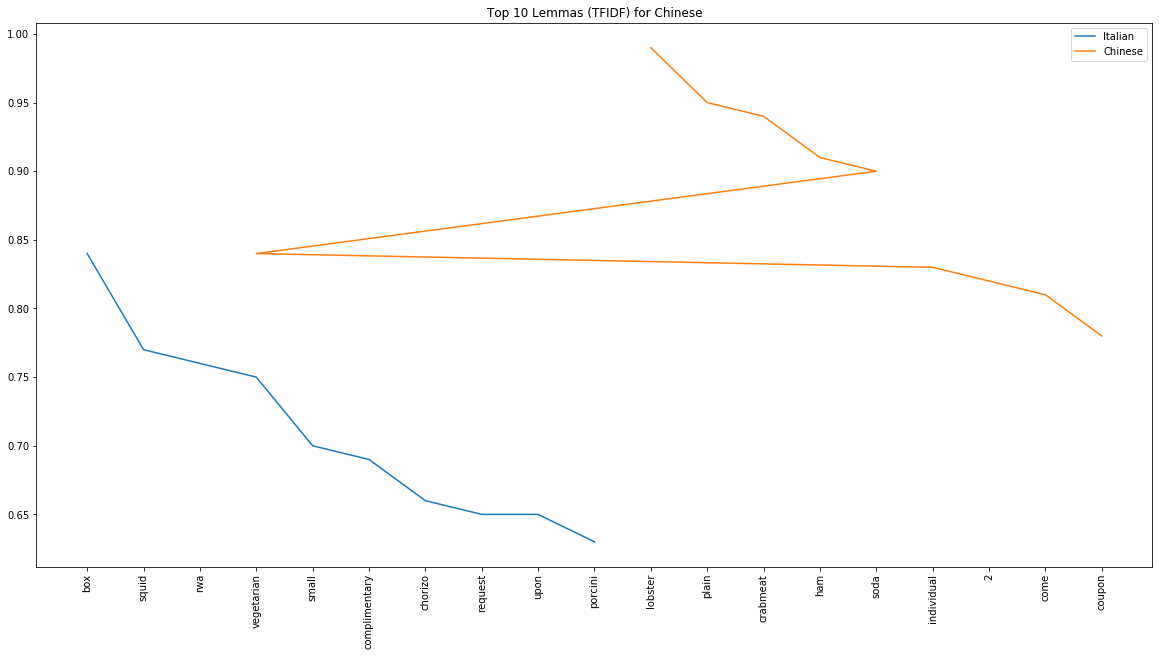

In [52]:
plt.figure(figsize = (20, 10))
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'italian']['Item Descriptions'], 'Italian')
plot_top_tfidf(menu_df[menu_df['Cuisine'] == 'chinese']['Item Descriptions'], 'Chinese')

plt.legend();

In [53]:
model = models.KeyedVectors.load('w2v_model_top100.model')

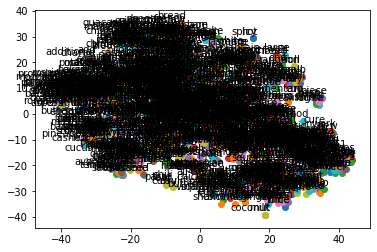

In [54]:
word2vec_tsne_plot(model)

In [55]:
model.most_similar('garlic')

[('sauteed', 0.8091986179351807),
 ('dice', 0.6805795431137085),
 ('parsley', 0.6780210733413696),
 ('paprika', 0.6750020384788513),
 ('herb', 0.666252851486206),
 ('eggplant', 0.662540853023529),
 ('boneless', 0.6503599882125854),
 ('w', 0.6476787328720093),
 ('sautéed', 0.6455574035644531),
 ('zucchini', 0.6182396411895752)]

In [56]:
doc_model = models.KeyedVectors.load('doc_model_top100.model')

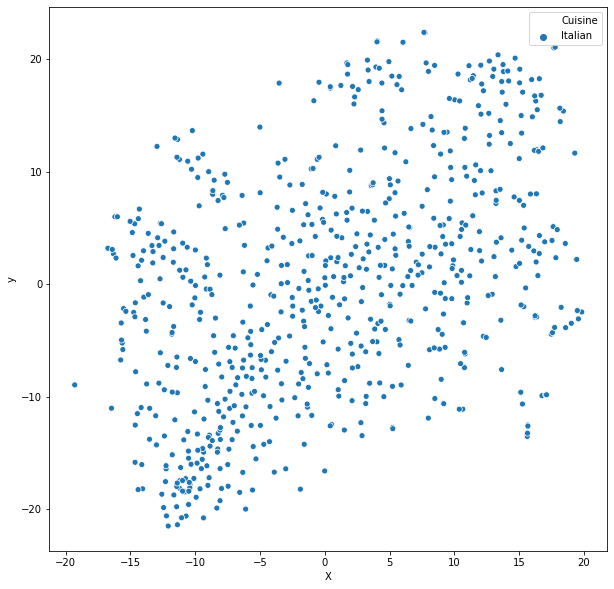

In [57]:
doc2vec_tsne_plot(doc_model, 'Italian')

In [58]:
doc_model.docvecs.most_similar([doc_model.docvecs.vectors_docs[1]], topn = 10)


[('1', 1.0),
 ('164', 0.9198294878005981),
 ('694', 0.9132099151611328),
 ('312', 0.8975053429603577),
 ('241', 0.8803262710571289),
 ('103', 0.8537753820419312),
 ('105', 0.8428245782852173),
 ('227', 0.8419506549835205),
 ('307', 0.8357695937156677),
 ('271', 0.8330426216125488)]